## Sprite Siamese Network
- Intended to be a "CLIP"-like text2image evaluator to determine which text encodings are closest to images using few-shot learning
- Code taken from the Siamese Network architecture used in the fingerprint clustering and from https://keras.io/examples/vision/siamese_network/

---

### NOTES

Overall
- trains very quickly, has intended output of a single distance value from a text to image comparison
- text embedding information may be getting too condensed and lost in the network

1-1 text to correct image / wrong image pairing
- too close in similarity for final distance
- gets it completely wrong between the pos / neg anchors sometimes

1-99 text to correct image / everything else pairings
- learns nothing; everything is perfectly in the middle (50% similarity)



#### Imports and Configuration

In [26]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# tensorflow
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape, Activation, Input, GlobalAveragePooling2D, Lambda

In [2]:
#import from Python folder to get the utils
import sys
sys.path.append('../Python')
from utils import picoSS2np, showMultiSprPalette, showMultiSprRGB, showSprRGB, showSprPalette, animatePal

In [3]:
### CONSTANT VARIABLES   ###

# PICO-8 Palette => use colormap for matplotlib
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']


Food Dataset shape: (100, 8, 8)
Char Dataset shape: (100, 8, 8)


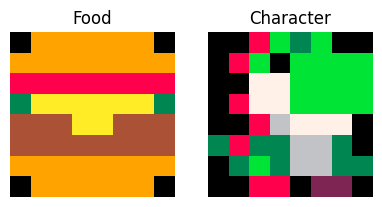

In [4]:
# import the dataset to use (pico-characters)

# import from the PICO sprites posted onto Twitter 
# Food: https://twitter.com/JUSTIN_CYR/status/634546317713391616
# Characters: https://twitter.com/johanvinet/status/635814153601597441
pico_food_dat = np.load('../data/rip_data/pico_food.npy',allow_pickle=True)
pico_char_dat = np.load('../data/rip_data/pico_characters.npy',allow_pickle=True)

print(f"Food Dataset shape: {pico_food_dat.shape}")
print(f"Char Dataset shape: {pico_char_dat.shape}")

# show a random food and character sprite 
rand_food = random.choice(pico_food_dat)
rand_char = random.choice(pico_char_dat)
showMultiSprPalette([rand_food,rand_char],textArr=['Food','Character'])

In [5]:
# get the text descriptions and convert to embeddings

# import sentence-transformer for text embedding 
SBERT_MODEL = SentenceTransformer('bert-base-nli-mean-tokens')

def sentEmb(txt):
    return SBERT_MODEL.encode([txt])[0]

# import the text data
pico_char_labels = np.array([l.strip() for l in open('../data/rip_data/character_desc.txt','r').readlines()])

# encode the labels
pico_char_labels_emb = []
with tqdm(total=len(pico_char_labels)) as pbar:
    pbar.set_description("Encoding labels")
    for l in pico_char_labels:
        pico_char_labels_emb.append(sentEmb(l))
        pbar.update(1)

Encoding labels: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


Character: a red robot dog


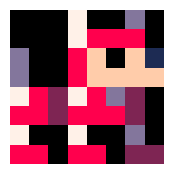

Encoding length: 768


In [6]:
# show a random character and its description
rand_char_idx = random.randint(0,len(pico_char_labels))
print(f"Character: {pico_char_labels[rand_char_idx]}")
showSprPalette(pico_char_dat[rand_char_idx])

desc_enc = pico_char_labels_emb[rand_char_idx]
print(f"Encoding length: {len(desc_enc)}")

In [152]:
# configure the training parameters
SIAM_CONFIG = {
    "EPOCHS": 0,
    "BATCH_SIZE": 16,
    "VAL_SPLIT": 0.1}

SIAM_CONFIG["MODEL_PATH"] = f"../models/siamese_txt2img/smn_pico_char-{SIAM_CONFIG['EPOCHS']}e.h5"

#### Siamese Network Setup

In [153]:
# pairs up one good image and one bad image to text (1-1)
def pairing_1_1(imgs, text):
    pairX = []    # texts - image
    pairY = []    # 1 for positive, 0 for negative

    imgs = np.expand_dims(imgs,axis=-1) # expand the dimensions of the images

    for i in range(len(imgs)):
        # pair text to the correct image (positive pair)
        pairX.append([text[i],imgs[i]])
        pairY.append(1)

        # [1-1 test]
        # pair text to a random image (negative pair)
        all_but_i = list(range(len(imgs)))
        rand_img = random.choice(all_but_i[:i] + all_but_i[i+1:])
        pairX.append([text[i],imgs[rand_img]])
        pairY.append(0)

    return np.array(pairX), np.array(pairY)

# pairs up the correct image to text with everything else as negative exampkes (1-99)
def pairing_1_99(imgs, text):
    pairX = []    # texts - image
    pairY = []    # 1 for positive, 0 for negative

    imgs = np.expand_dims(imgs,axis=-1) # expand the dimensions of the images

    for i in range(len(imgs)):
        # pair text to the correct image (positive pair)
        pairX.append([text[i],imgs[i]])
        pairY.append(1)

        # [1-99 test]
        # pair off the rest of the images to the text (negative pair)  
        for j in range(len(imgs)):
            if j != i:
                pairX.append([text[i],imgs[j]])
                pairY.append(0)

    return np.array(pairX), np.array(pairY)

# split data into train and validation sets
def train_val_split(X,y,vperc=0.1):
    # shuffle the data
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # split the data
    split = int(len(X) * (1-vperc))
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]

    return X_train, X_val, y_train, y_val


In [154]:
# make the training data
X_dat, y_dat = pairing_1_1(pico_char_dat, pico_char_labels_emb)

# split into train and validation sets
X_train, X_val, y_train, y_val = train_val_split(X_dat, y_dat, vperc=SIAM_CONFIG["VAL_SPLIT"])

Xt_dat_txt = np.array([t for t in X_train[:,0]])
Xt_dat_img = np.array([i for i in X_train[:,1]])

Xv_dat_txt = np.array([t for t in X_val[:,0]])
Xv_dat_img = np.array([i for i in X_val[:,1]])

print(f"X_dat_txt shape: {Xt_dat_txt.shape}")
print(f"X_dat_img shape: {Xt_dat_img.shape}")
print(f"y_train shape: {y_train.shape}")

print("")
print(f"Xv_dat_txt shape: {Xv_dat_txt.shape}")
print(f"Xv_dat_img shape: {Xv_dat_img.shape}")
print(f"y_val shape: {y_val.shape}")

X_dat_txt shape: (180, 768)
X_dat_img shape: (180, 8, 8, 1)
y_train shape: (180,)

Xv_dat_txt shape: (20, 768)
Xv_dat_img shape: (20, 8, 8, 1)
y_val shape: (20,)


/var/folders/5h/0zjb1m296y1gvhtd9q40w4yc0000gn/T/ipykernel_9235/1356692895.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pairX), np.array(pairY)


In [155]:
# feature extracting siamese network
def siamese_model(inputShape, embeddingDim=64):
    model = Sequential()
    model.add(Input(inputShape))
    
    model.add(Conv2D(16, (2, 2), padding="same", activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(32, (2, 2), padding="same", activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (2, 2), padding="same", activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # model.add(Conv2D(128, (2, 2), padding="same", activation="relu"))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(embeddingDim))
    
    model.summary()
    
    return model
    

In [156]:
# siamese loss function for few-shot learning
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    
    # calculate the contrastive loss between the true labels and the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    
    return loss

# euclidean distance calculation to determine similarity between text 2 image
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (fa, fb) = vectors
    
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(fa - fb), axis=1,keepdims=True)
    
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [157]:
# CREATE THE ENTIRE SIAMESE NETWORK ARCHITECTURE

GEN_INPUT_SHAPE = (8,8,1)
TEXT_INPUT_SHAPE = (768,)

#####     make the anchor, positive, negative inputs     #####

# text first (anchor) - reshape from 768 to 8x8x1
textIn = Sequential()
textIn.add(Input(TEXT_INPUT_SHAPE))
textIn.add(Dense(np.prod(GEN_INPUT_SHAPE)))
textIn.add(Reshape(GEN_INPUT_SHAPE))
# textIn.add(Lambda(lambda x: K.cast(x, dtype='float32')))
textIn.summary()

# image second (positive, negative)
imgIn = Input(GEN_INPUT_SHAPE)

#####     get the features from the siamese model     #####

featureExtractor = siamese_model(GEN_INPUT_SHAPE)
featsA = Model(inputs=textIn.input, outputs=featureExtractor(textIn.output)).output
featsB = featureExtractor(imgIn)

print(type(featsA))
print(type(featsB))


#construct the siamese network + compile
distance = euclidean_distance([featsA, featsB])
smn = Model(inputs=[textIn.input, imgIn], outputs=distance)
smn.summary()
smn.compile(loss=contrastive_loss, optimizer="adam")

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                49216     
                                                                 
 reshape_26 (Reshape)        (None, 8, 8, 1)           0         
                                                                 
Total params: 49,216
Trainable params: 49,216
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 8, 8, 16)          80        
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                          

In [158]:
# sanity check the model
print(f"Text input shape: {textIn.input_shape}")
print(f"Image input shape: {imgIn.shape}")
print(f"Feature A shape: {featsA.shape}")
print(f"Feature B shape: {featsB.shape}")
print(f"Distance shape: {distance.shape}")

print(f"Siamse network input shape: {smn.input_shape}")

Text input shape: (None, 768)
Image input shape: (None, 8, 8, 1)
Feature A shape: (None, 64)
Feature B shape: (None, 64)
Distance shape: (None, 1)
Siamse network input shape: [(None, 768), (None, 8, 8, 1)]


#### Run Siamese Network

In [159]:
# plot the training history
def plot_training(H):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    if "val_loss" in H.history:
        plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.show()

Epoch 1/100
12/12 [==============================] - 2s 25ms/step - loss: 61.4701 - val_loss: 1.7414
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 11.5878 - val_loss: 0.5114
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 4.7530 - val_loss: 0.2780
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 2.5068 - val_loss: 0.2676
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 2.0487 - val_loss: 0.2934
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 1.5326 - val_loss: 0.3222
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 1.0609 - val_loss: 0.3465
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 0.9522 - val_loss: 0.3689
Epoch 9/100
12/12 [==============================] - 0s 6ms/step - loss: 0.7932 - val_loss: 0.3961
Epoch 10/100
12/12 [==============================] - 0s 6ms/step - loss: 0.7335 - val_loss: 0.4194
Epoch 

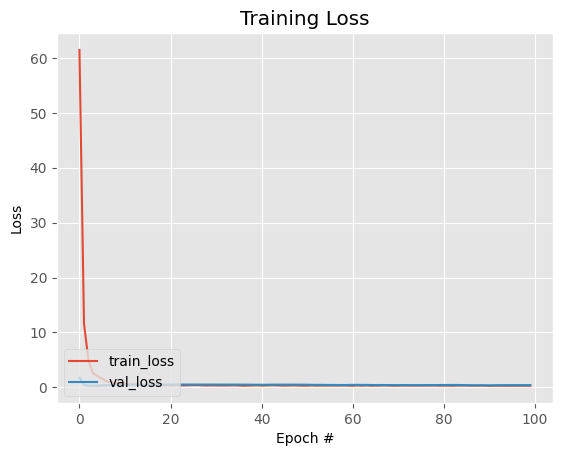

In [160]:
# train the model
# with tf.device('/device:GPU:0'):
history = smn.fit(
    [Xt_dat_txt, Xt_dat_img], y_train,
    validation_data=([Xv_dat_txt, Xv_dat_img], y_val),
    batch_size=SIAM_CONFIG['BATCH_SIZE'],
    epochs=SIAM_CONFIG['EPOCHS'],
    shuffle=True)

plot_training(history)
smn.save(SIAM_CONFIG["MODEL_PATH"])

#### Test the model output

In [161]:
NUM_TEST_PAIRS = 5

# get some random samples
# rand_i = random.sample(range(len(pico_char_dat)), NUM_TEST_PAIRS)
rand_not_i = random.sample(range(len(pico_char_dat)), NUM_TEST_PAIRS)

# preset samples for comparison
rand_i = [21,53,90,96,99,30]  #tails, finn, link, samus, pikachu, leonardo
rand_not_i.append(31)  # add raphael
# rand_not_i = [0,1,2,3,4,5]  # 


# get the text and image (and bad imgs)
test_txt = pico_char_labels[rand_i]
test_txt_emb = np.array(pico_char_labels_emb)[rand_i]
test_img = pico_char_dat[rand_i]
test_not_img = pico_char_dat[rand_not_i]

# show the prediction output from the model
pos = smn.predict([[test_txt_emb], [test_img]])
neg = smn.predict([[test_txt_emb], [test_not_img]])

# print(pos.shape)
# print(neg.shape)

1/1 [==============================] - 0s 53ms/step


Text: an orange fox with red shoes


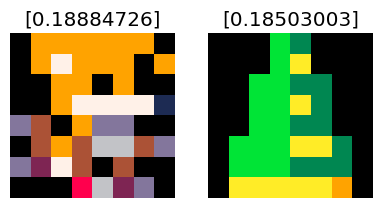

Text: a boy with a white hat with ears, blue shirt and black pants wearing a green backpack


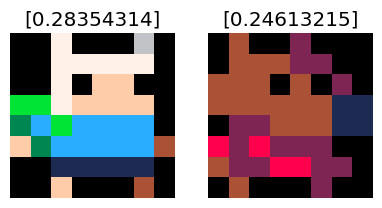

Text: a man with green clothes and yellow hair with a sword and shield


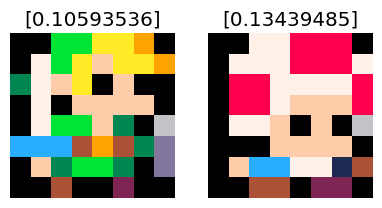

Text: a robot with a red helmet and green glasses with an orange suit and blue gun


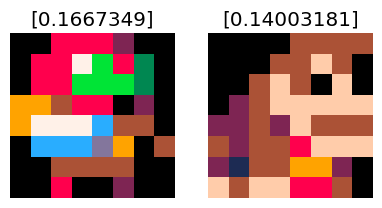

Text: a yellow monster with black ears and red cheeks


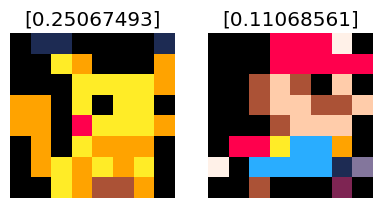

Text: a green turtle standing up with a blue bandana on its eyes


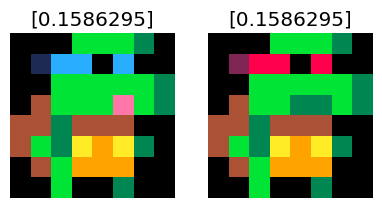

In [162]:
# show the output
for i in range(len(test_txt)):
    print(f"Text: {test_txt[i]}")
    showMultiSprPalette([test_img[i],test_not_img[i]],textArr=[pos[i],neg[i]])
